## Import & Data Load

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import bisect
import missingno as ms
import statsmodels.api as sm

from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [2]:
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

| 항목                 | 설명                                                             |
|---------------------|------------------------------------------------------------------|
| ARI_CO              | 도착항의 소속국가(도착항 앞 2글자)                                |
| ARI_PO              | 도착항의 항구명(도착항 뒤 글자)                                  |
| SHIP_TYPE_CATEGORY  | 선종 통합 바탕으로 5대 선종으로 분류                              |
| DIST                | 정박지(ber_port)와 접안지 사이의 거리                              |
| ATA                 | anc_port에 도착한 시점의 utc. 실제 정박 시각(Actual Time of Arrival) |
| ID                  | 선박식별 일련번호                                                  |
| BREADTH             | 선박의 폭                                                         |
| BUILT               | 선박의 연령                                                       |
| DEADWEIGHT          | 선박의 재화중량톤수                                               |
| DEPTH               | 선박의 깊이                                                       |
| DRAUGHT             | 흘수 높이                                                        |
| GT                  | 용적톤수(Gross Tonnage)값                                        |
| LENGTH              | 선박의 길이                                                       |
| SHIPMANAGER         | 선박 소유주                                                       |
| FLAG                | 선박의 국적                                                       |
| U_WIND              | 풍향 u벡터                                                        |
| V_WIND              | 풍향 v벡터                                                        |
| AIR_TEMPERATURE     | 기온                                                              |
| BN                  | 보퍼트 풍력 계급                                                  |
| ATA_LT              | anc_port에 도착한 시점의 현지 정박 시각(Local Time of Arrival)(단위 : H) |
| DUBAI               | 해당일의 두바이유 값                                              |
| BRENT               | 해당일의 브렌트유 값                                              |
| WTI                 | 해당일의 WTI 값                                                  |
| BDI_ADJ             | 조정된 벌크운임지수                                                |
| PORT_SIZE           | 접안지 폴리곤 영역의 크기                                         |
| CI_HOUR  | 대기시간 |           |


In [3]:
train = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_AI_Challenge\train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_AI_Challenge\test.csv').drop(columns=['SAMPLE_ID'])

display(train)
display(test)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,10.0,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,10.0,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,CN,YRT6,Bulk,59.018184,2017-11-11 22:23,J661243,40.0,13,93200,20.0,...,NaN,NaN,NaN,6,61.25,62.21,55.70,1333.609109,0.000360,65.850000
367437,JP,QYY1,Tanker,0.000000,2022-04-29 2:58,D847216,10.0,9,1280,0.0,...,0.87,17.1,1.028558,11,105.37,109.34,104.69,1955.103846,0.000552,0.000000
367438,SG,GIW5,Container,1.768630,2022-07-14 7:58,Q635545,30.0,6,25000,20.0,...,3.36,31.7,2.557156,15,97.73,99.10,95.78,1601.291086,0.002615,0.997500
367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07,N211282,10.0,8,2400,10.0,...,-2.44,10.8,3.055715,19,49.75,50.08,47.02,1191.353331,0.000069,0.000000


,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE
0,JP,HYG5,Tanker,9.508139,2022-08-27 8:29,R721438,20.0,9,5510,10.0,...,0.18,0.63,26.8,0.850060,17,97.88,96.49,89.55,766.977634,0.000256
1,SG,GIW5,Container,24.186684,2022-03-27 20:57,G185231,40.0,14,109000,20.0,...,-0.81,-0.77,27.5,1.213528,4,98.14,104.64,100.60,1655.006791,0.002615
2,TW,EKP8,Cargo,0.000000,2023-01-18 2:06,P862781,20.0,14,13700,10.0,...,-6.25,-12.57,16.1,6.557436,10,83.70,84.98,79.48,682.595117,0.000427
3,JP,HYG5,Bulk,0.000000,2016-08-02 0:59,B415437,10.0,18,2840,10.0,...,NaN,NaN,NaN,NaN,9,38.85,41.80,39.51,629.378100,0.000256
4,SG,GIW5,Container,19.834186,2023-01-24 0:27,J412562,30.0,23,30700,20.0,...,1.58,-4.47,23.8,3.180123,8,83.88,86.13,80.13,563.101921,0.002615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244984,RU,ZME5,Bulk,1.625700,2018-10-22 2:49,R355837,10.0,35,3120,10.0,...,NaN,NaN,NaN,NaN,4,74.42,76.17,66.82,1435.584535,0.000011
244985,RU,ZME5,Bulk,30.642841,2019-06-08 20:00,P438645,30.0,17,46400,20.0,...,0.00,0.00,12.5,0.000000,22,64.88,66.55,58.47,1245.535239,0.000011
244986,CN,RGT8,Cargo,0.000000,2017-03-30 11:26,R763233,20.0,12,5280,10.0,...,NaN,NaN,NaN,NaN,19,50.71,52.96,50.35,1274.203155,0.000026
244987,VN,ONW1,Container,0.000000,2022-08-10 7:20,F587712,20.0,27,7020,10.0,...,1.64,-1.85,25.4,2.060279,14,94.89,97.40,91.93,1265.314398,0.000006


In [4]:
train = train.rename(columns = {
    'ARI_CO' : '도착항의 소속국가',
    'ARI_PO' : '도착항의 항구명',
    'SHIP_TYPE_CATEGORY' : '5대 선종',
    'DIST' : '거리',
    'ATA' : '실제 정박 시각',
    'ID' : '일련번호',
    'BREADTH' : '선박의 폭',
    'BUILT' : '선박의 연령',
    'DEADWEIGHT' : '선박의 재화중량톤수',
    'DEPTH' : '선박의 깊이',
    'DRAUGHT' : '흘수 높이',
    'GT' : '용적톤수 값',
    'LENGTH' : '선박의 길이',
    'SHIPMANAGER' : '선박 소유주',
    'FLAG' : '선박의 국적',
    'U_WIND' : '풍향 U벡터',
    'V_WIND' : '풍향 V벡터',
    'AIR_TEMPERATURE' : '기온',
    'BN' : '보퍼트 풍력 계급',
    'ATA_LT' : '현지 정박 시각',
    'DUBAI' : '두바이유 값',
    'BRENT' : '브렌트유 값',
    'WTI' : 'WTI값',
    'BDI_ADJ' : '벌크운임지수',
    'PORT_SIZE' : '폴리곤 영역의 크기',
    'CI_HOUR' : '대기시간'
})

test = test.rename(columns = {
    'ARI_CO' : '도착항의 소속국가',
    'ARI_PO' : '도착항의 항구명',
    'SHIP_TYPE_CATEGORY' : '5대 선종',
    'DIST' : '거리',
    'ATA' : '실제 정박 시각',
    'ID' : '일련번호',
    'BREADTH' : '선박의 폭',
    'BUILT' : '선박의 연령',
    'DEADWEIGHT' : '선박의 재화중량톤수',
    'DEPTH' : '선박의 깊이',
    'DRAUGHT' : '흘수 높이',
    'GT' : '용적톤수 값',
    'LENGTH' : '선박의 길이',
    'SHIPMANAGER' : '선박 소유주',
    'FLAG' : '선박의 국적',
    'U_WIND' : '풍향 U벡터',
    'V_WIND' : '풍향 V벡터',
    'AIR_TEMPERATURE' : '기온',
    'BN' : '보퍼트 풍력 계급',
    'ATA_LT' : '현지 정박 시각',
    'DUBAI' : '두바이유 값',
    'BRENT' : '브렌트유 값',
    'WTI' : 'WTI값',
    'BDI_ADJ' : '벌크운임지수',
    'PORT_SIZE' : '폴리곤 영역의 크기'
})

In [5]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367441 entries, 0 to 367440
Data columns (total 26 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   도착항의 소속국가   367441 non-null  object 
 1   도착항의 항구명    367441 non-null  object 
 2   5대 선종       367441 non-null  object 
 3   거리          367441 non-null  float64
 4   실제 정박 시각    367441 non-null  object 
 5   일련번호        367441 non-null  object 
 6   선박의 폭       367440 non-null  float64
 7   선박의 연령      367441 non-null  int64  
 8   선박의 재화중량톤수  367441 non-null  int64  
 9   선박의 깊이      367440 non-null  float64
 10  흘수 높이       367440 non-null  float64
 11  용적톤수 값      367441 non-null  int64  
 12  선박의 길이      367440 non-null  float64
 13  선박 소유주      367441 non-null  object 
 14  선박의 국적      367441 non-null  object 
 15  풍향 U벡터      213955 non-null  float64
 16  풍향 V벡터      213955 non-null  float64
 17  기온          213076 non-null  float64
 18  보퍼트 풍력 계급   213955 non-null  float64
 19  현지

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244989 entries, 0 to 244988
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   도착항의 소속국가   244989 non-null  object 
 1   도착항의 항구명    244989 non-null  object 
 2   5대 선종       244989 non-null  object 
 3   거리          244989 non-null  float64
 4   실제 정박 시각    244989 non-null  object 
 5   일련번호        244989 non-null  object 
 6   선박의 폭       244989 non-null  float64
 7   선박의 연령      244989 non-null  int64  
 8   선박의 재화중량톤수  244989 non-null  int64  
 9   선박의 깊이      244989 non-null  float64
 10  흘수 높이       244989 non-null  float64
 11  용적톤수 값      244989 non-null  int64  
 12  선박의 길이      244989 non-null  float64
 13  선박 소유주      244989 non-null  object 
 14  선박의 국적      244989 non-null  object 
 15  풍향 U벡터      143062 non-null  float64
 16  풍향 V벡터      143062 non-null  float64
 17  기온          142478 non-null  float64
 18  보퍼트 풍력 계급   143062 non-null  float64
 19  현지

None

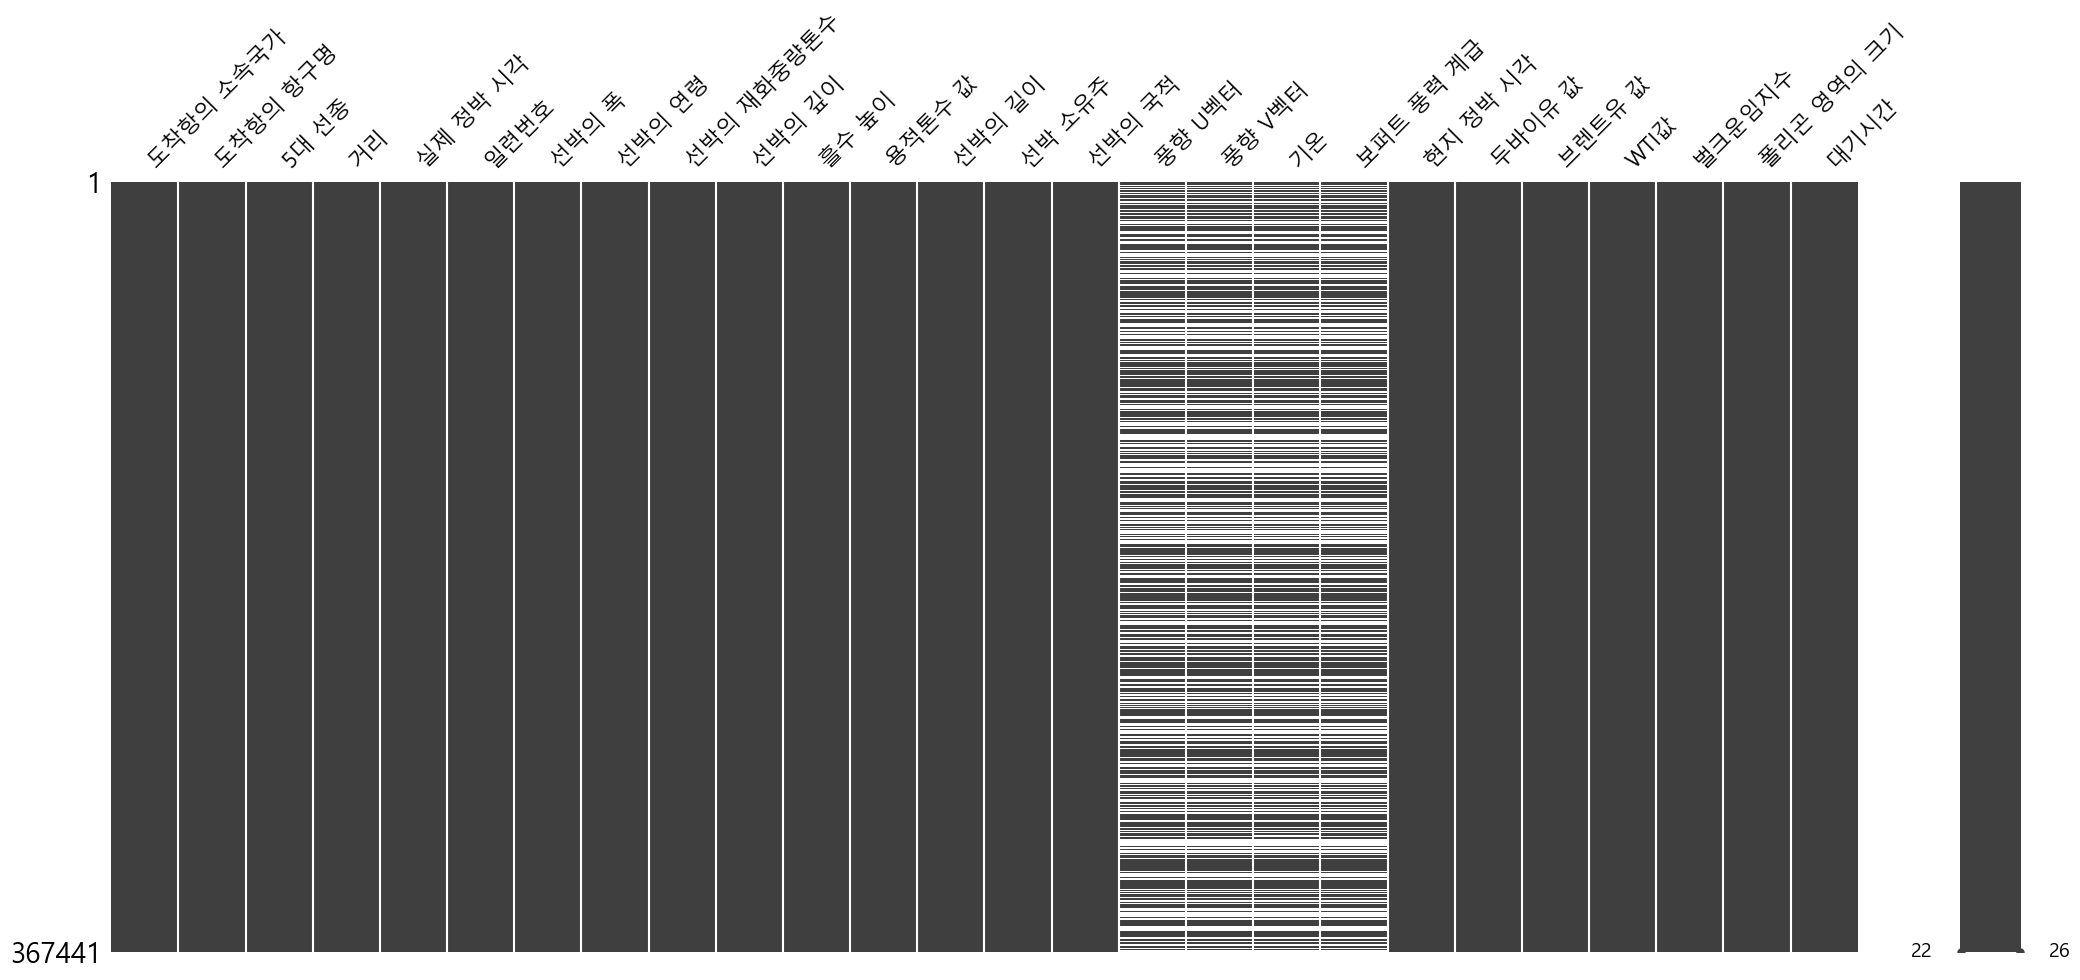

<Figure size 2000x2000 with 0 Axes>

In [6]:
ms.matrix(train)
plt.figure(figsize = (20, 20))
plt.show()

In [7]:
display(train.describe())
display(test.describe())

,거리,선박의 폭,선박의 연령,선박의 재화중량톤수,선박의 깊이,흘수 높이,용적톤수 값,선박의 길이,풍향 U벡터,풍향 V벡터,기온,보퍼트 풍력 계급,현지 정박 시각,두바이유 값,브렌트유 값,WTI값,벌크운임지수,폴리곤 영역의 크기,대기시간
count,367441.000000,367440.000000,367441.000000,367441.000000,367440.000000,367440.000000,367441.000000,367440.000000,213955.000000,213955.000000,213076.000000,213955.000000,367441.000000,367441.000000,367441.00000,367441.000000,367441.000000,367441.000000,367441.000000
mean,19.315929,30.550239,14.746082,63588.867056,16.476540,11.086708,41346.606612,205.114468,-0.297587,-0.262955,18.867344,2.706476,11.837903,65.533814,67.55712,63.209494,1348.251333,0.000877,61.877118
std,30.903272,10.957441,7.040392,63558.705308,6.047015,4.600020,39311.578997,75.867383,3.365912,3.735113,9.727090,1.387629,6.645665,20.916641,20.98516,20.630433,738.961048,0.000838,170.575224
min,0.000000,10.000000,0.000000,100.000000,0.000000,0.000000,150.000000,20.000000,-25.330000,-21.450000,-32.200000,0.000000,0.000000,13.520000,19.33000,-37.630000,286.802297,0.000005,0.000000
25%,0.000000,20.000000,10.000000,14400.000000,10.000000,10.000000,10000.000000,150.000000,-2.150000,-2.280000,12.200000,1.804286,7.000000,50.020000,51.46000,48.360000,836.349201,0.000142,0.000000
50%,6.929929,30.000000,13.000000,47400.000000,20.000000,10.000000,30700.000000,190.000000,-0.130000,0.000000,21.600000,2.618063,12.000000,62.930000,64.62000,59.140000,1187.573732,0.000552,7.949444
75%,25.693063,40.000000,18.000000,81400.000000,20.000000,10.000000,52100.000000,260.000000,1.540000,2.000000,26.600000,3.556008,17.000000,76.880000,79.30000,74.250000,1660.987616,0.001614,49.153333
max,199.980651,60.000000,80.000000,404000.000000,30.000000,20.000000,237000.000000,400.000000,17.910000,29.690000,47.600000,11.179660,23.000000,127.860000,127.98000,123.700000,4795.865609,0.002615,2159.130556


,거리,선박의 폭,선박의 연령,선박의 재화중량톤수,선박의 깊이,흘수 높이,용적톤수 값,선박의 길이,풍향 U벡터,풍향 V벡터,기온,보퍼트 풍력 계급,현지 정박 시각,두바이유 값,브렌트유 값,WTI값,벌크운임지수,폴리곤 영역의 크기
count,244989.000000,244989.000000,244989.000000,244989.000000,244989.000000,244989.000000,244989.000000,244989.00000,143062.000000,143062.000000,142478.000000,143062.000000,244989.000000,244989.000000,244989.000000,244989.000000,244989.000000,244989.000000
mean,19.323158,30.531126,14.752609,63471.097559,16.464658,11.085314,41266.175869,204.97157,-0.290605,-0.271904,18.897629,2.710436,11.842748,65.571594,67.598318,63.259342,1352.148317,0.000876
std,30.945678,10.941687,7.064262,63381.428581,6.039802,4.588975,39187.091356,75.82823,3.387977,3.741679,9.721022,1.393537,6.644369,20.971688,21.052072,20.698380,743.293675,0.000838
min,0.000000,10.000000,0.000000,100.000000,0.000000,0.000000,150.000000,20.00000,-25.330000,-20.880000,-31.800000,0.000000,0.000000,13.520000,19.330000,-37.630000,286.802297,0.000005
25%,0.000000,20.000000,10.000000,14100.000000,10.000000,10.000000,10000.000000,150.00000,-2.140000,-2.270000,12.200000,1.801892,7.000000,50.020000,51.460000,48.360000,836.349201,0.000142
50%,6.900627,30.000000,13.000000,47200.000000,20.000000,10.000000,30500.000000,190.00000,-0.130000,0.000000,21.600000,2.614572,12.000000,62.930000,64.620000,59.150000,1189.335045,0.000552
75%,25.637684,40.000000,18.000000,81500.000000,20.000000,10.000000,51900.000000,260.00000,1.550000,2.000000,26.600000,3.559797,17.000000,77.020000,79.350000,74.290000,1671.272214,0.001614
max,199.997495,70.000000,71.000000,404000.000000,30.000000,20.000000,237000.000000,400.00000,18.450000,29.690000,47.200000,11.179660,23.000000,127.860000,127.980000,123.700000,4795.865609,0.002615


## Data Pre-processing

In [8]:
# datetime 컬럼 처리
train['실제 정박 시각'] = pd.to_datetime(train['실제 정박 시각'])
test['실제 정박 시각'] = pd.to_datetime(test['실제 정박 시각'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['실제 정박 시각'].dt.year
    df['month'] = df['실제 정박 시각'].dt.month
    df['day'] = df['실제 정박 시각'].dt.day
    df['hour'] = df['실제 정박 시각'].dt.hour
    df['minute'] = df['실제 정박 시각'].dt.minute
    df['weekday'] = df['실제 정박 시각'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='실제 정박 시각', inplace=True)
test.drop(columns='실제 정박 시각', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['도착항의 소속국가', '도착항의 항구명', '5대 선종', '일련번호', '선박 소유주', '선박의 국적']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]


In [9]:
train.fillna(train.mean(), inplace = True)
test.fillna(test.mean(), inplace = True)

## 시각화

<Axes: >

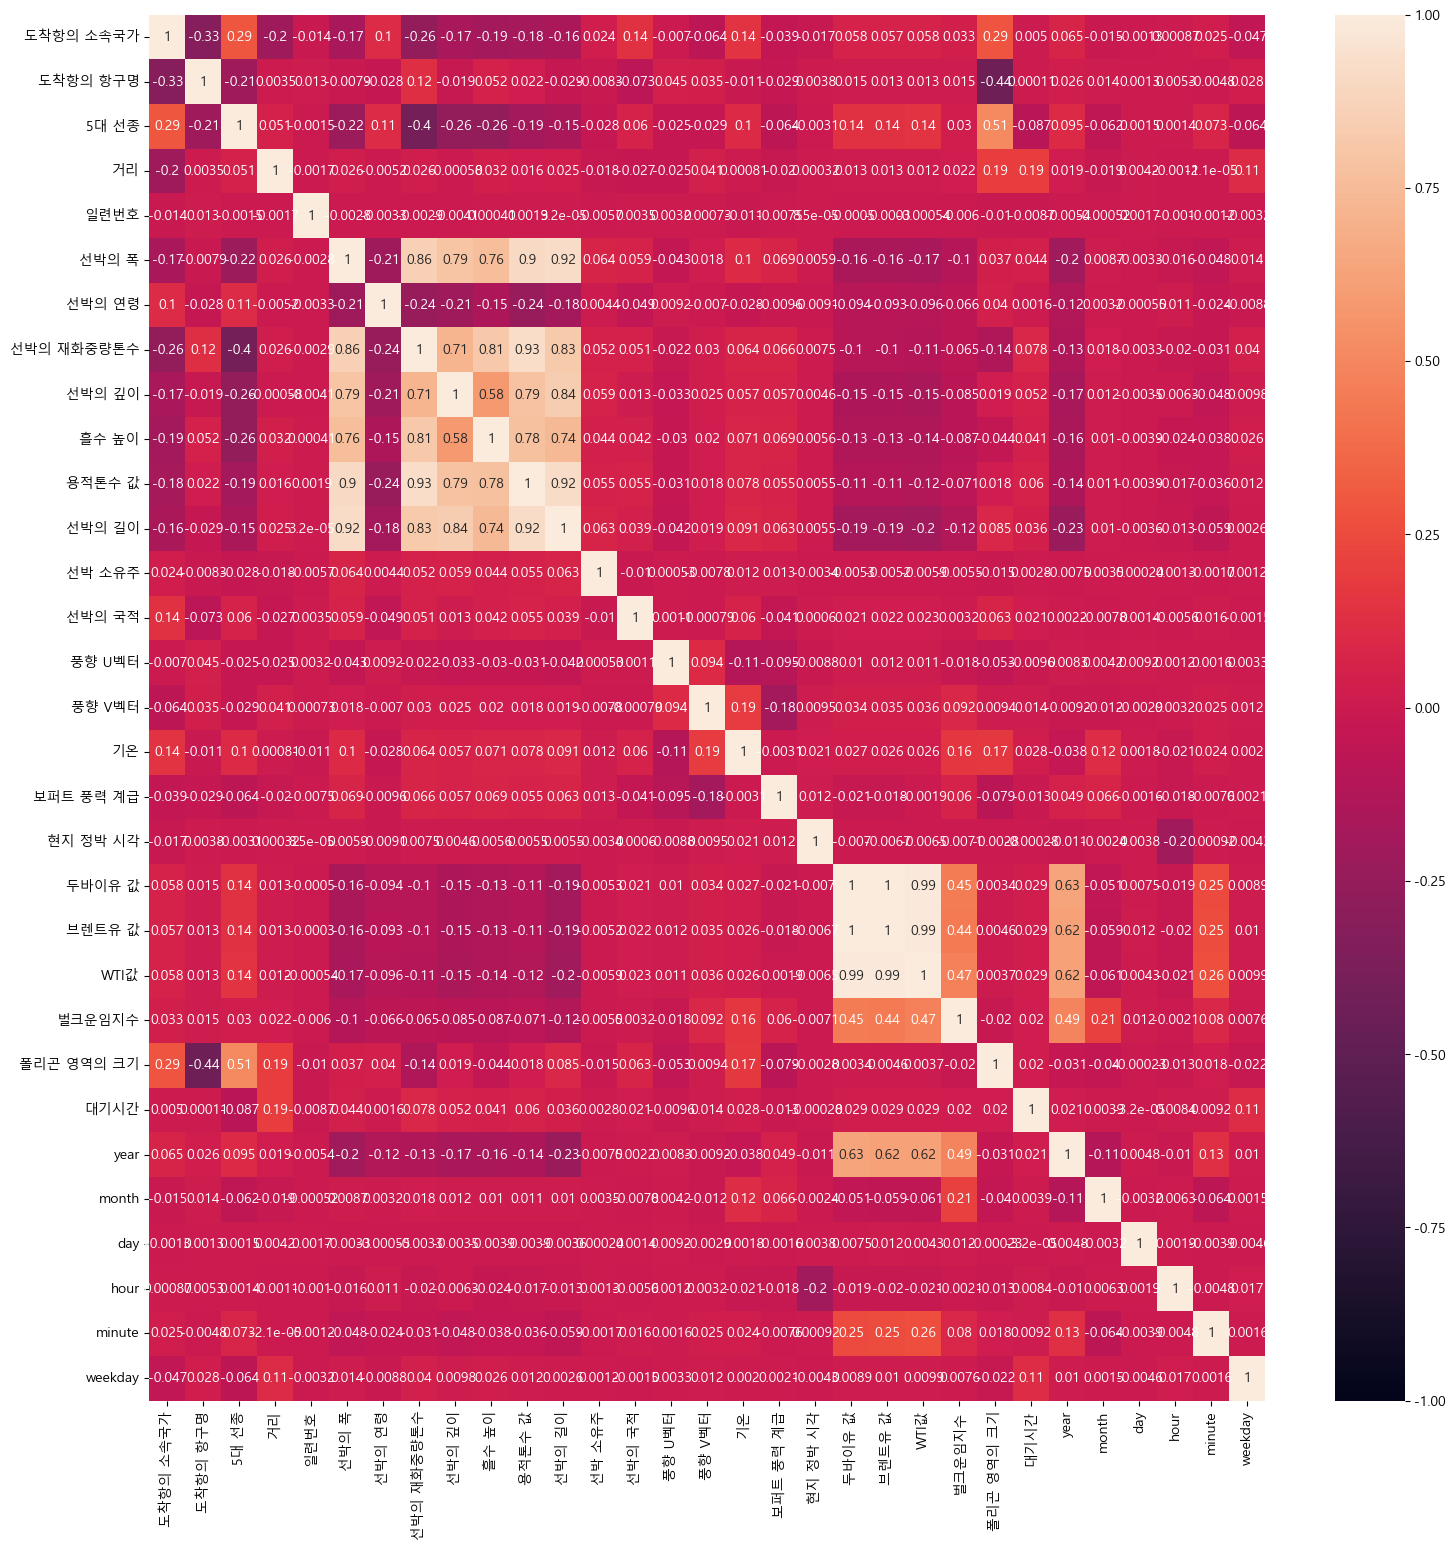

In [10]:
plt.figure(figsize = (18, 18))
sns.heatmap(train.corr(), vmin = -1, vmax = 1, annot = True)

C:\Users\dlwks\AppData\Local\Temp\ipykernel_4356\1289591921.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (20, 20))


<Figure size 2000x2000 with 0 Axes>

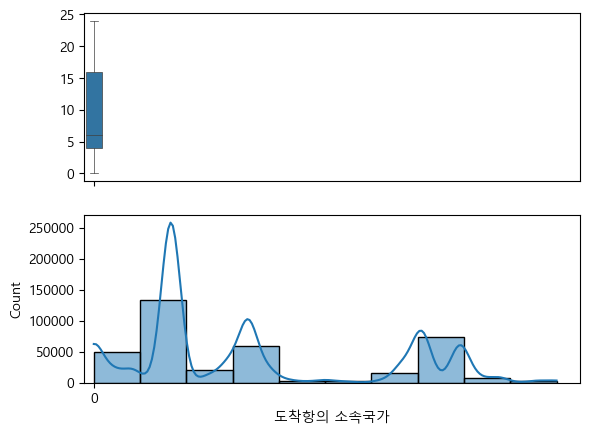

<Figure size 2000x2000 with 0 Axes>

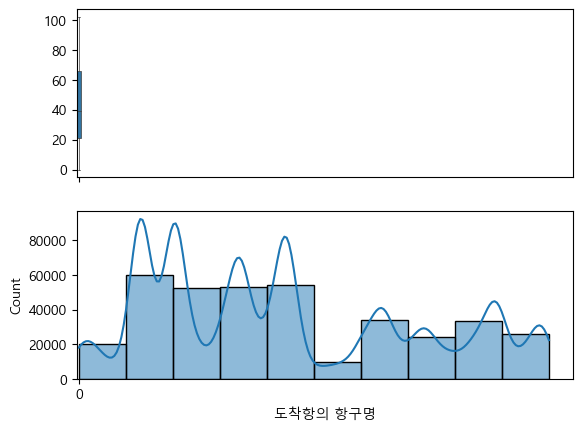

<Figure size 2000x2000 with 0 Axes>

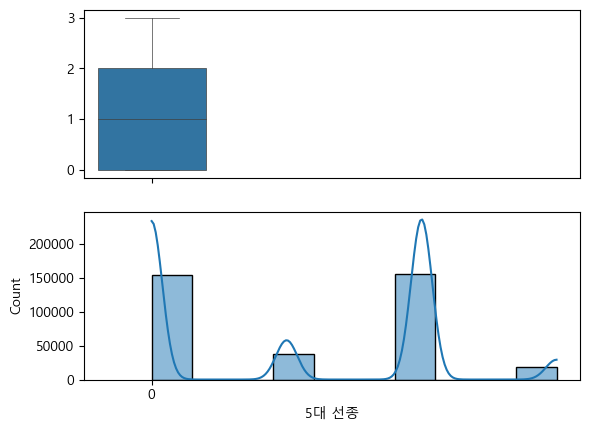

<Figure size 2000x2000 with 0 Axes>

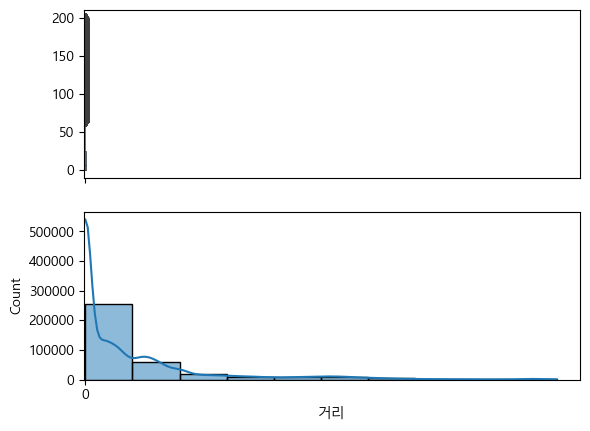

<Figure size 2000x2000 with 0 Axes>

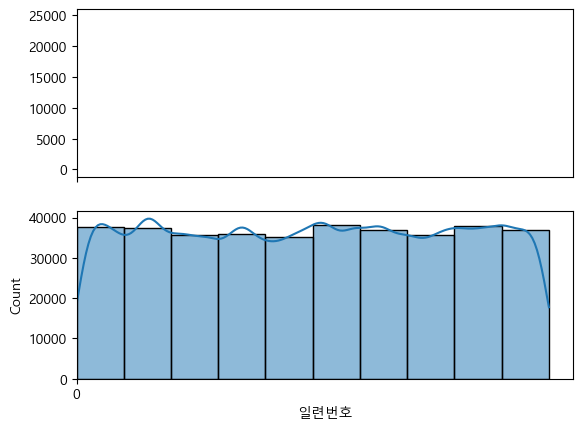

<Figure size 2000x2000 with 0 Axes>

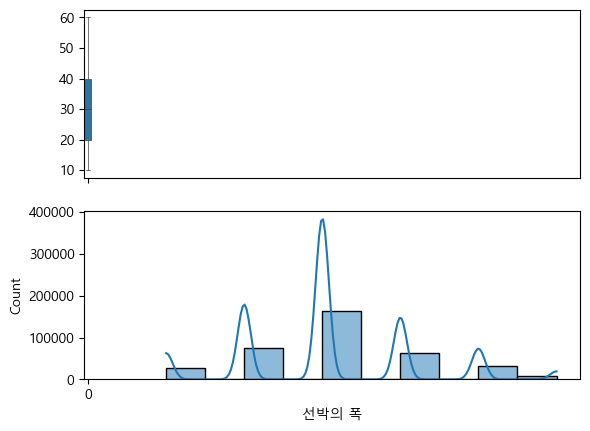

<Figure size 2000x2000 with 0 Axes>

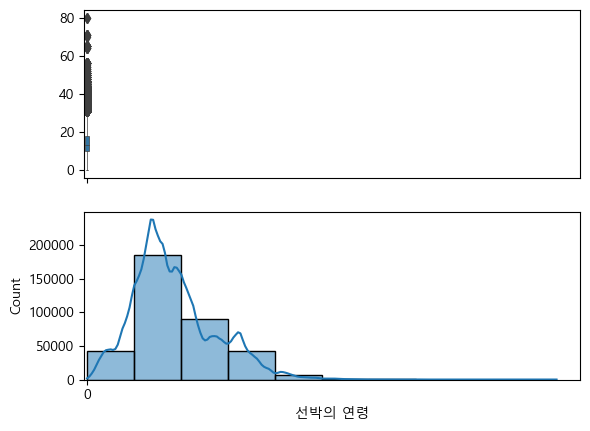

<Figure size 2000x2000 with 0 Axes>

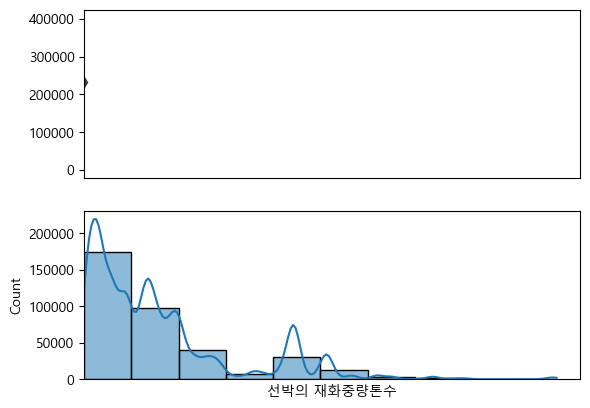

<Figure size 2000x2000 with 0 Axes>

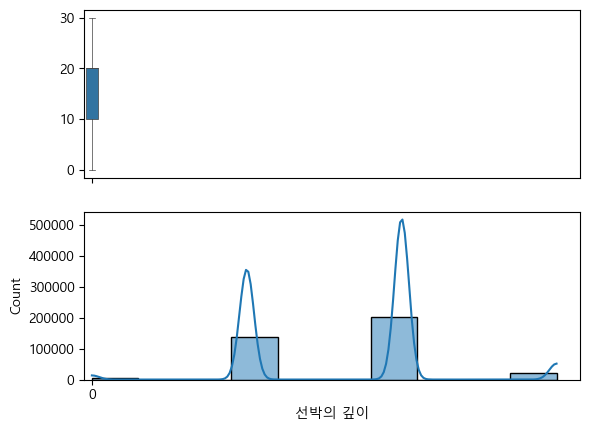

<Figure size 2000x2000 with 0 Axes>

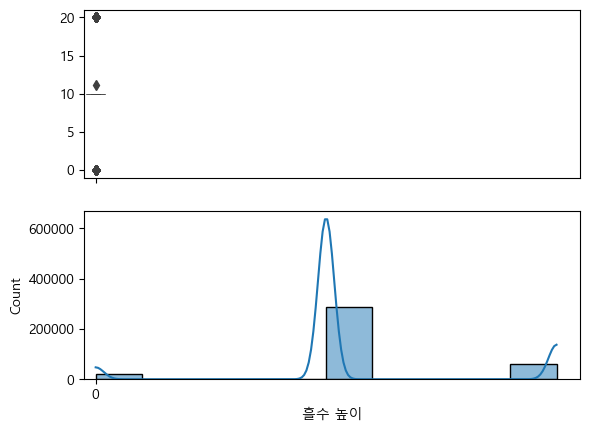

<Figure size 2000x2000 with 0 Axes>

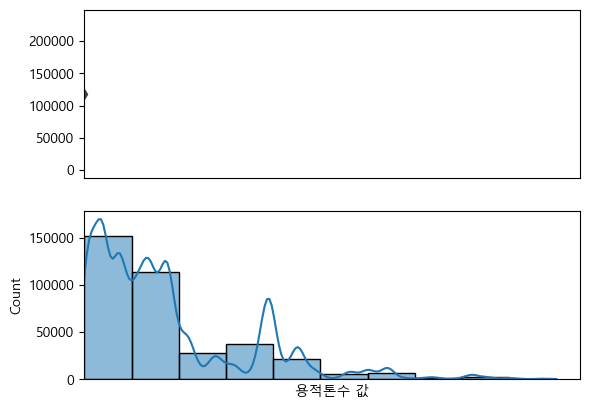

<Figure size 2000x2000 with 0 Axes>

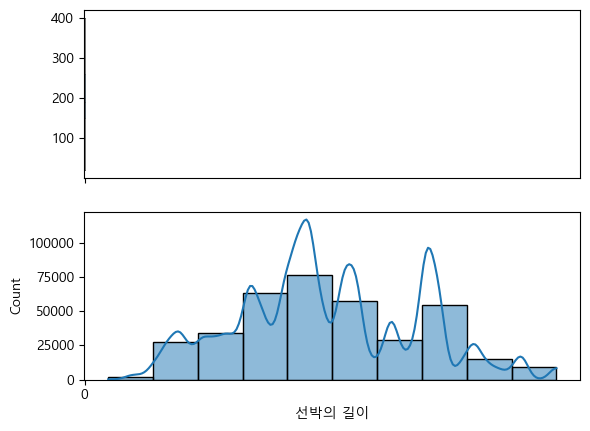

<Figure size 2000x2000 with 0 Axes>

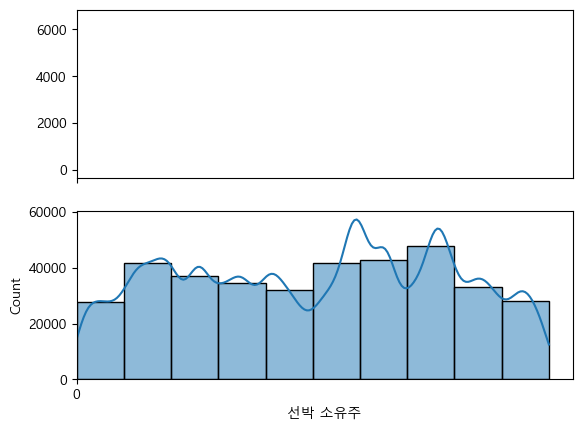

<Figure size 2000x2000 with 0 Axes>

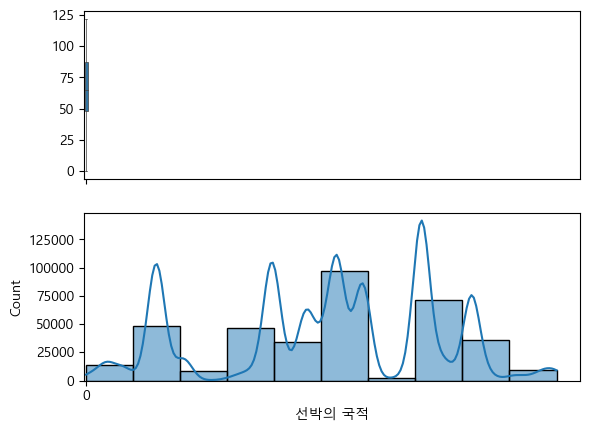

<Figure size 2000x2000 with 0 Axes>

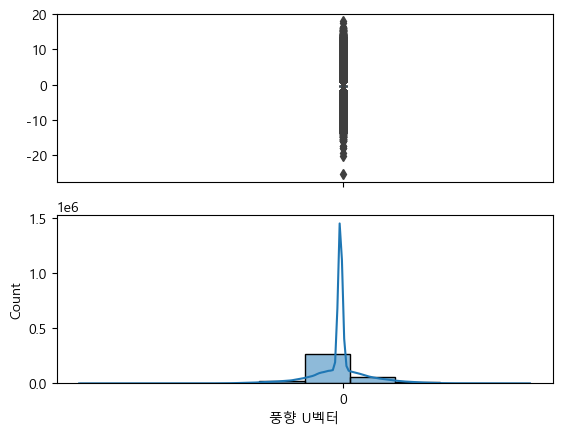

<Figure size 2000x2000 with 0 Axes>

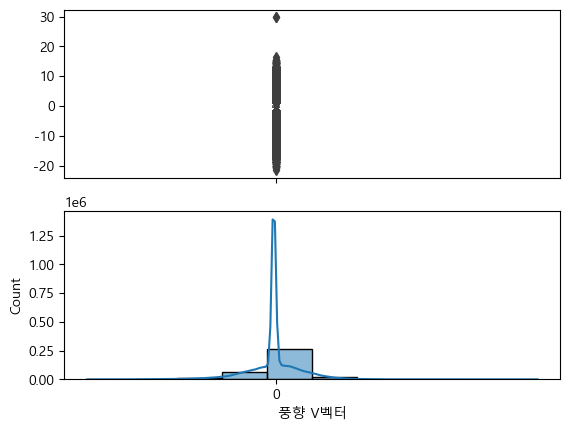

<Figure size 2000x2000 with 0 Axes>

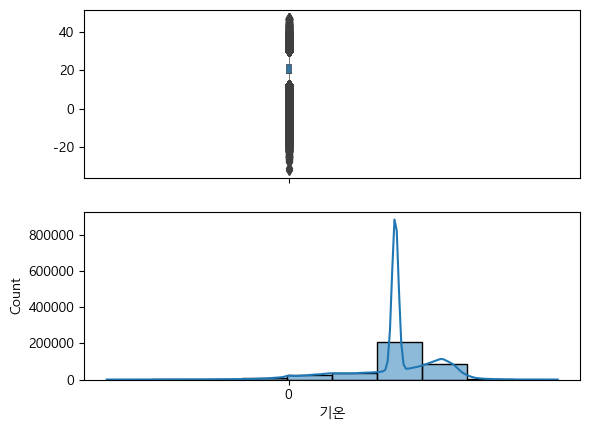

<Figure size 2000x2000 with 0 Axes>

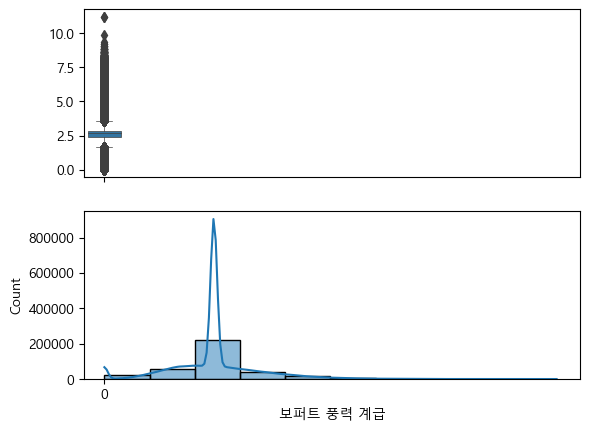

<Figure size 2000x2000 with 0 Axes>

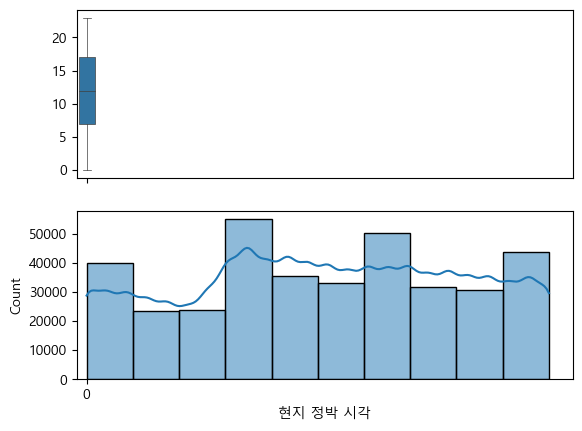

<Figure size 2000x2000 with 0 Axes>

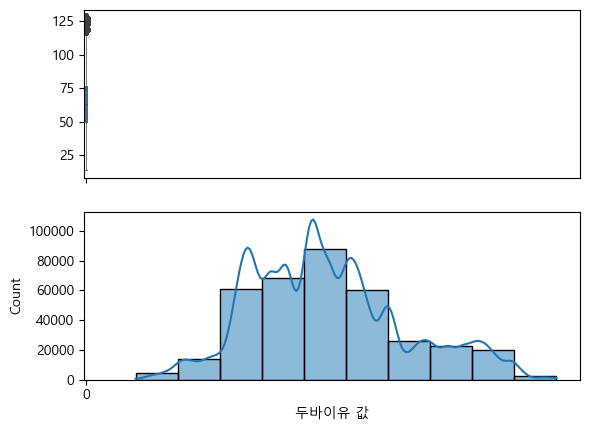

<Figure size 2000x2000 with 0 Axes>

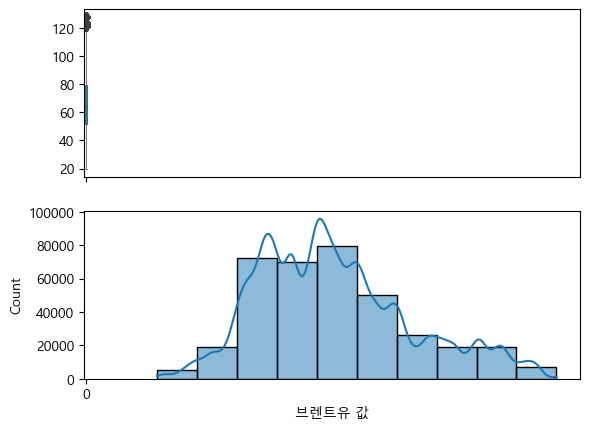

<Figure size 2000x2000 with 0 Axes>

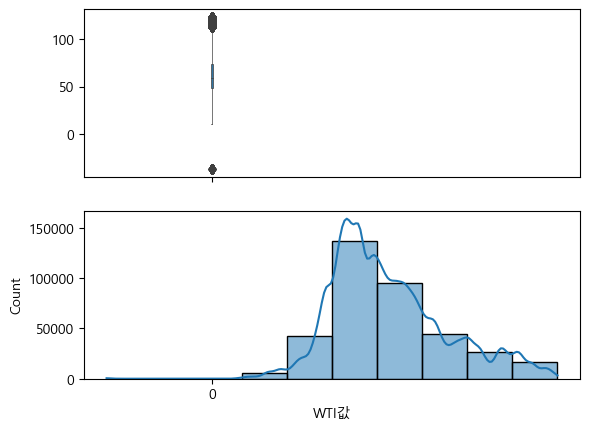

<Figure size 2000x2000 with 0 Axes>

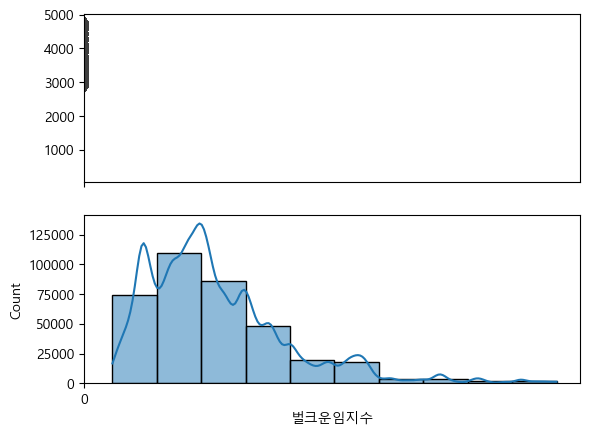

<Figure size 2000x2000 with 0 Axes>

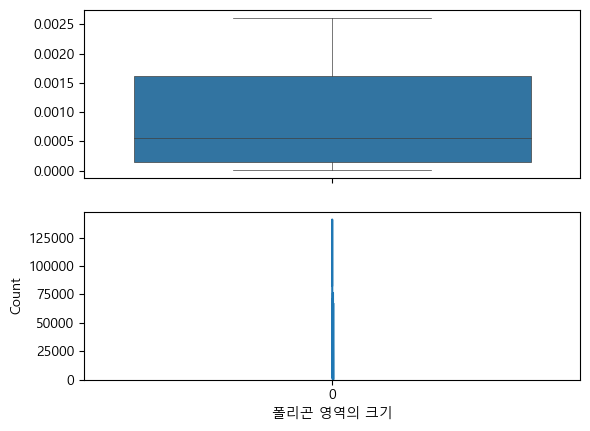

<Figure size 2000x2000 with 0 Axes>

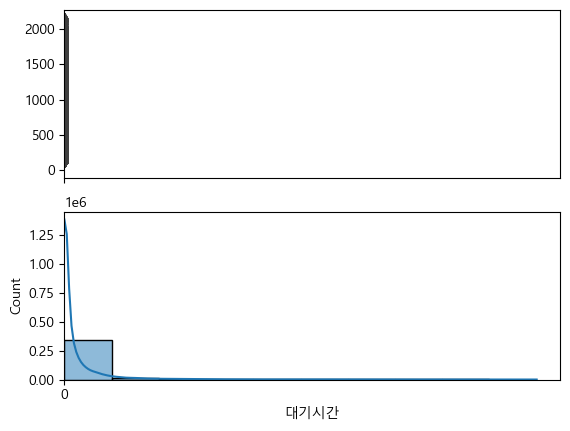

<Figure size 2000x2000 with 0 Axes>

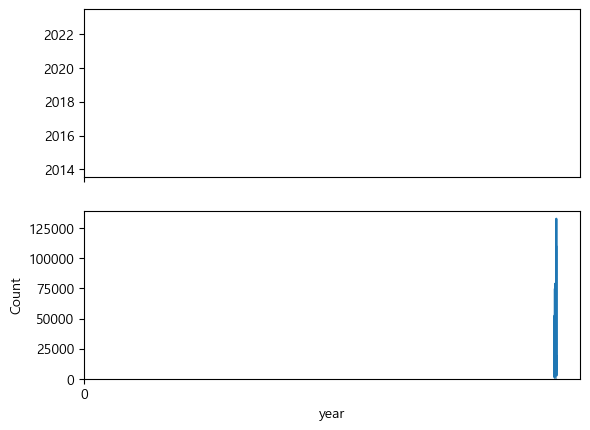

<Figure size 2000x2000 with 0 Axes>

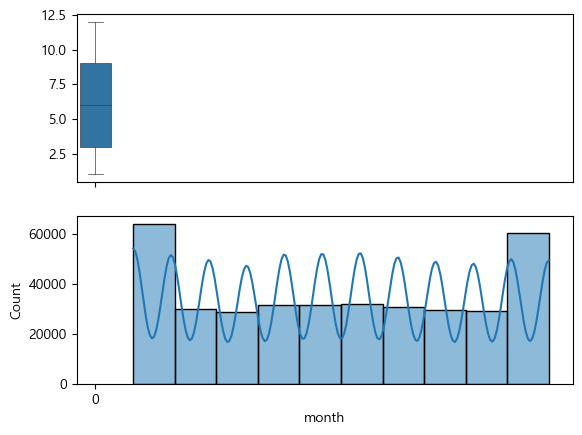

<Figure size 2000x2000 with 0 Axes>

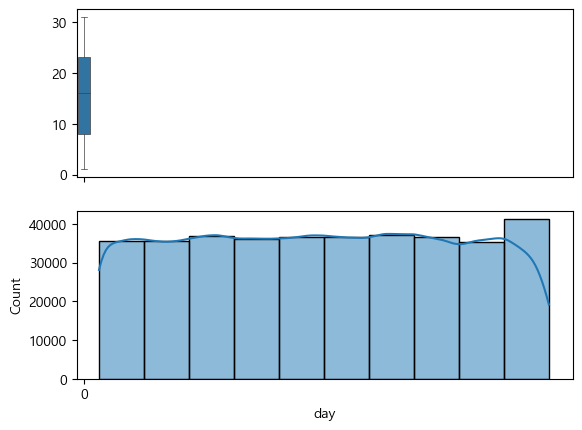

<Figure size 2000x2000 with 0 Axes>

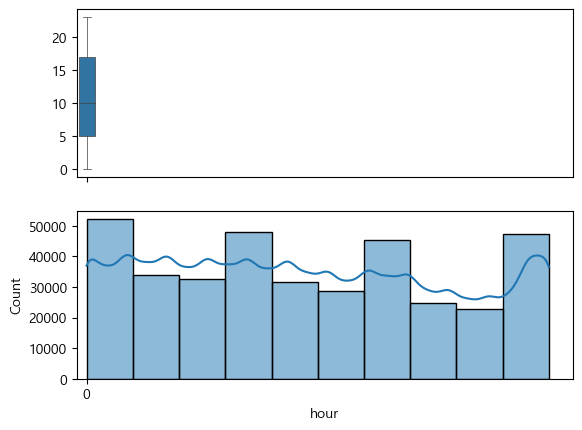

<Figure size 2000x2000 with 0 Axes>

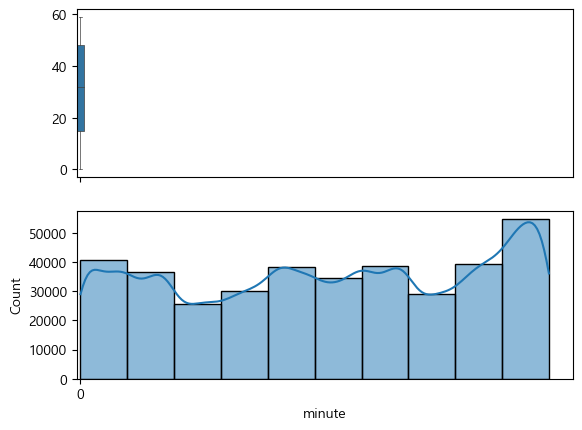

<Figure size 2000x2000 with 0 Axes>

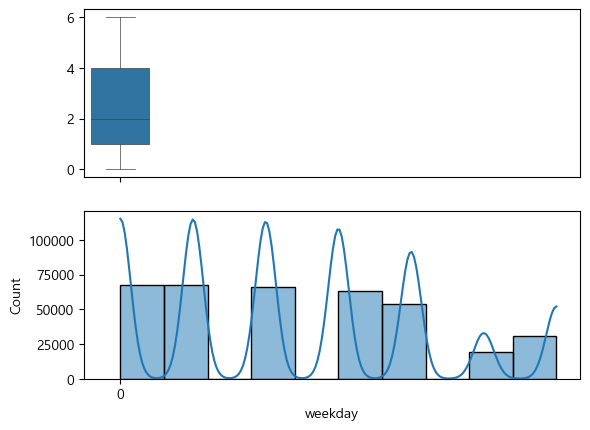

In [11]:
features = train.columns
numeric_features = train.select_dtypes('number').columns
categorical_features = train.select_dtypes('object').columns
for i in numeric_features:
  plt.figure(figsize = (20, 20))
  plt.tight_layout()
  f, (ax_box, ax_hist) = plt.subplots(2, sharex = True)
  sns.boxplot(train[i], ax = ax_box, linewidth = 0.5)
  sns.histplot(train[i], ax = ax_hist, bins = 10, kde = True)

numeric cols : 31
Index(['도착항의 소속국가', '도착항의 항구명', '5대 선종', '거리', '일련번호', '선박의 폭', '선박의 연령',
       '선박의 재화중량톤수', '선박의 깊이', '흘수 높이', '용적톤수 값', '선박의 길이', '선박 소유주', '선박의 국적',
       '풍향 U벡터', '풍향 V벡터', '기온', '보퍼트 풍력 계급', '현지 정박 시각', '두바이유 값', '브렌트유 값',
       'WTI값', '벌크운임지수', '폴리곤 영역의 크기', '대기시간', 'year', 'month', 'day', 'hour',
       'minute', 'weekday'],
      dtype='object')


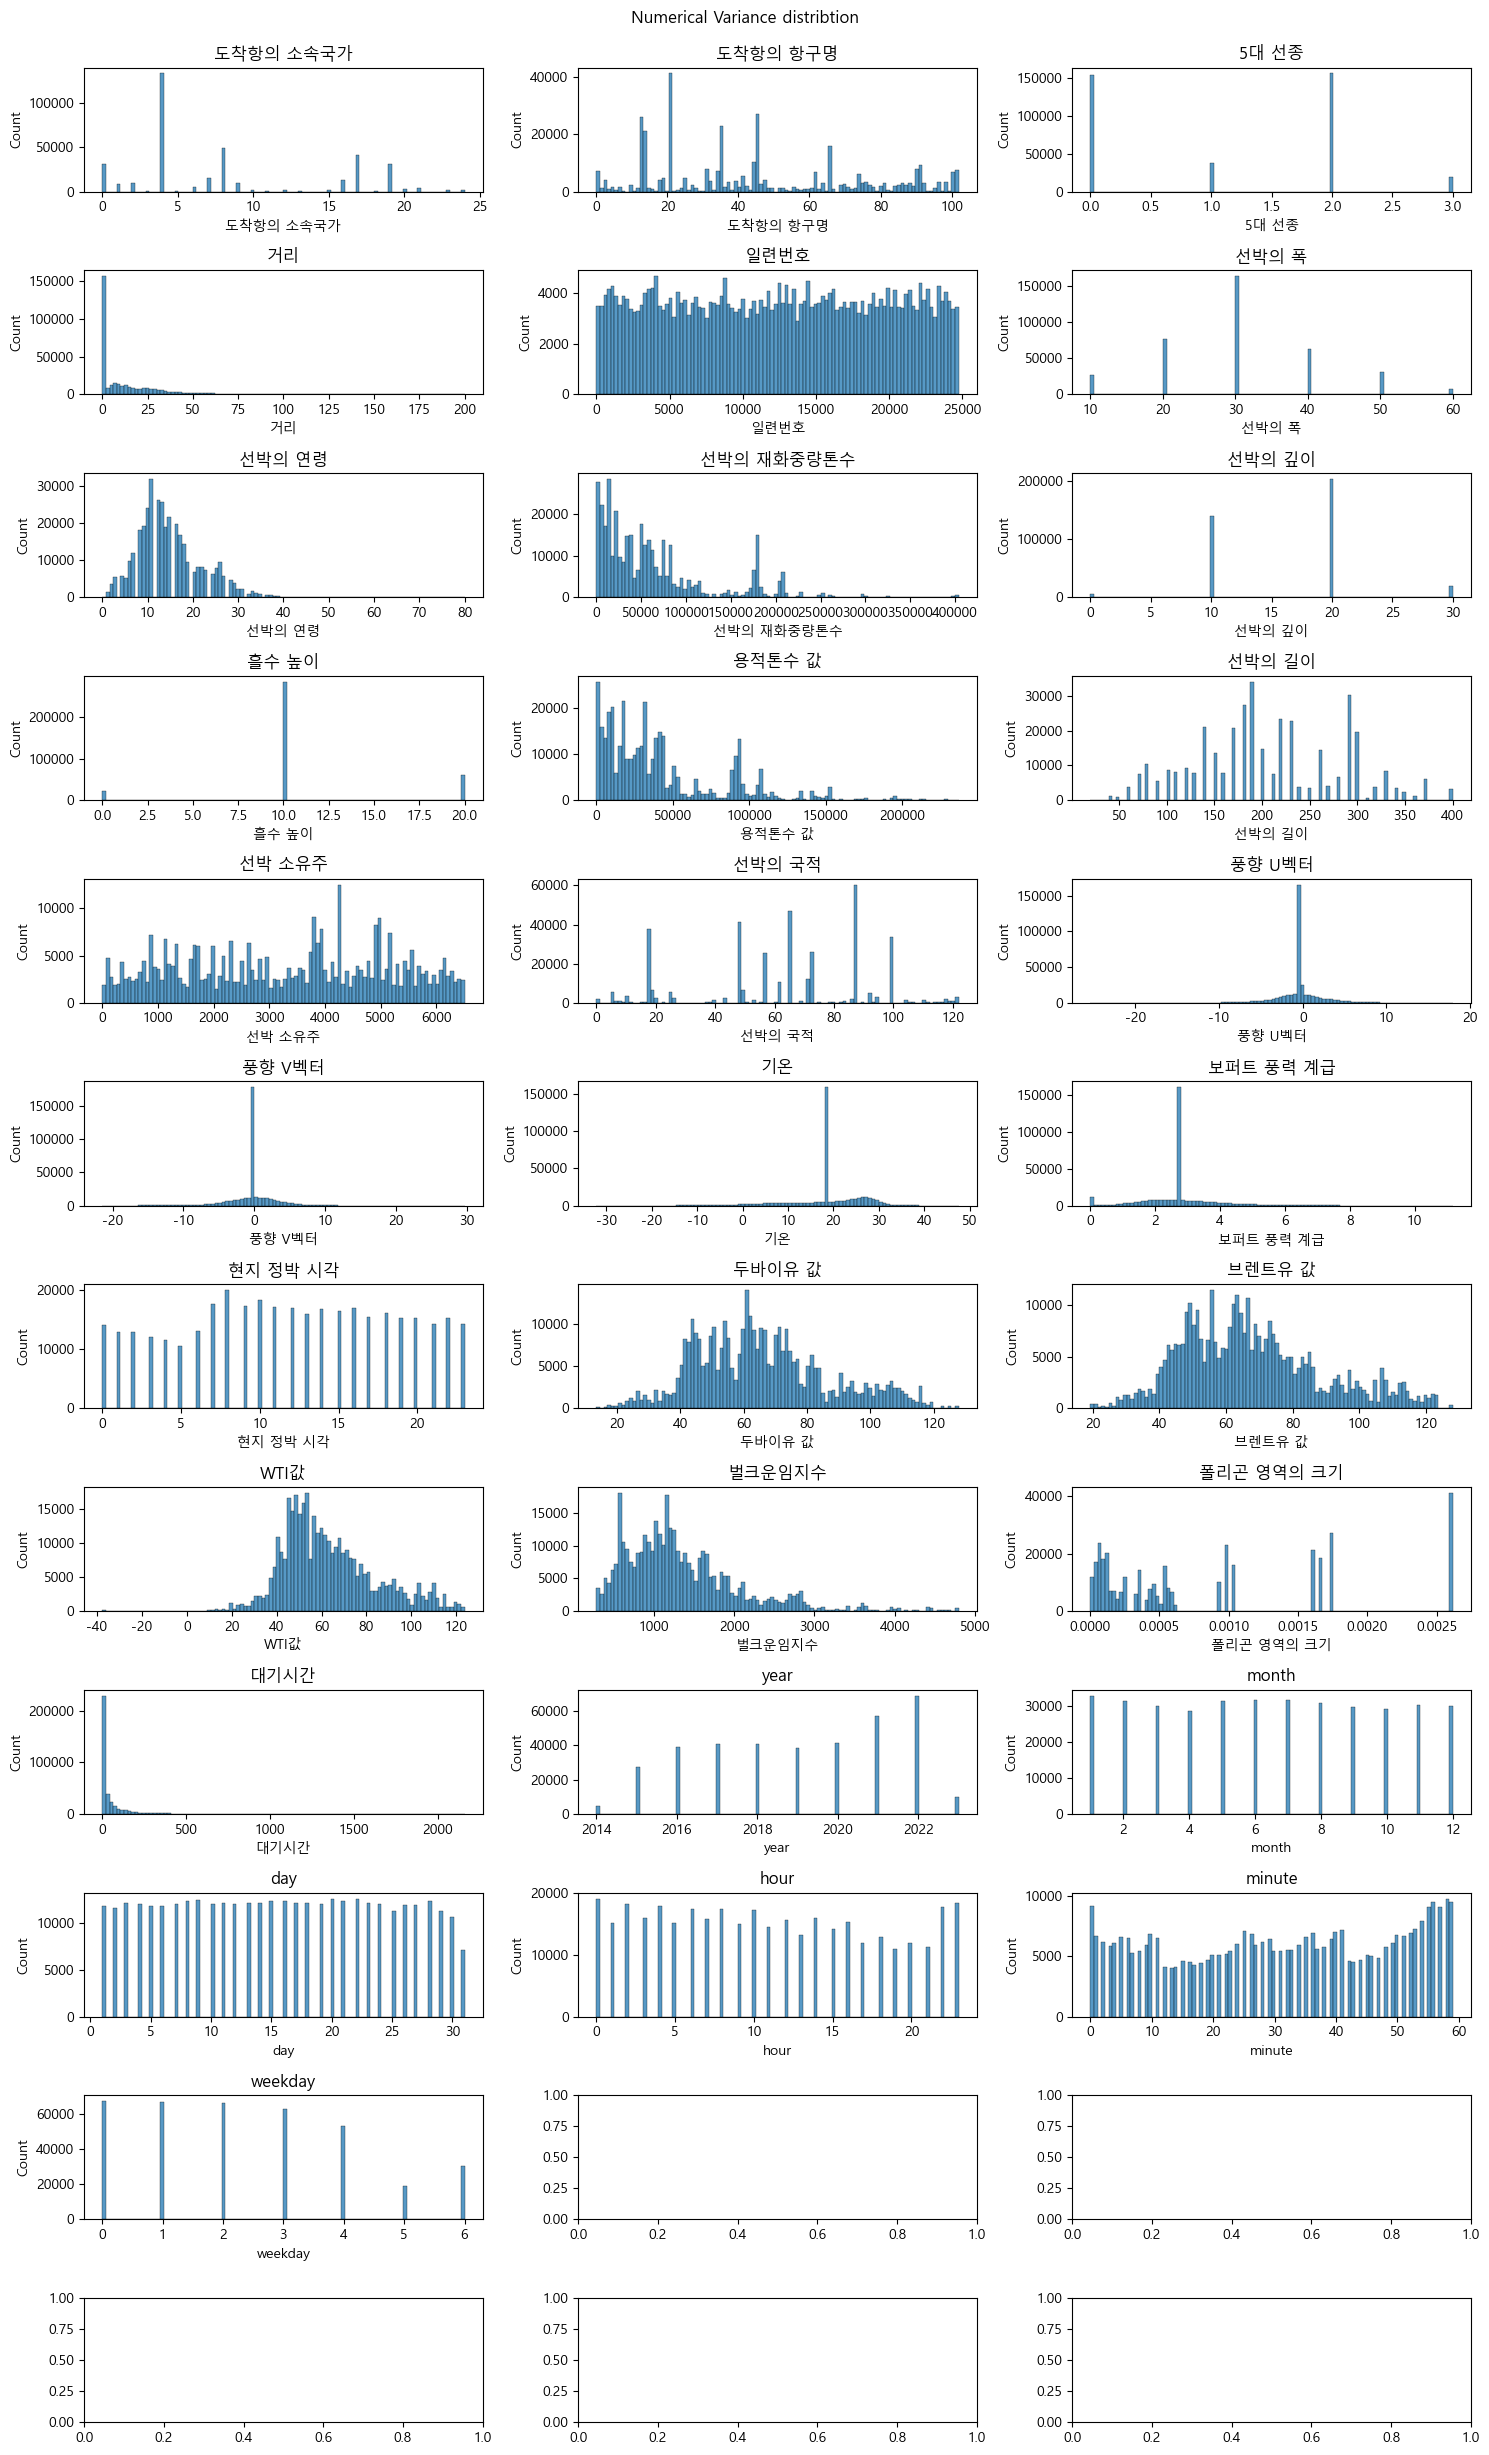

In [16]:
cols_numeric = train.describe().columns

print(f'numeric cols : {len(cols_numeric)}')
print(f'{cols_numeric}')

fig, ax = plt.subplots(12, 3, figsize=(15, 25))

for i in range(len(cols_numeric)):

    x = i // 3    
    y = i % 3
    
    sns.histplot(x=cols_numeric[i], data = train, bins=100, ax=ax[x,y])
    ax[x, y].set_title(cols_numeric[i])

plt.suptitle('Numerical Variance distribtion\n\n')
plt.tight_layout()
plt.show()
plt.close()

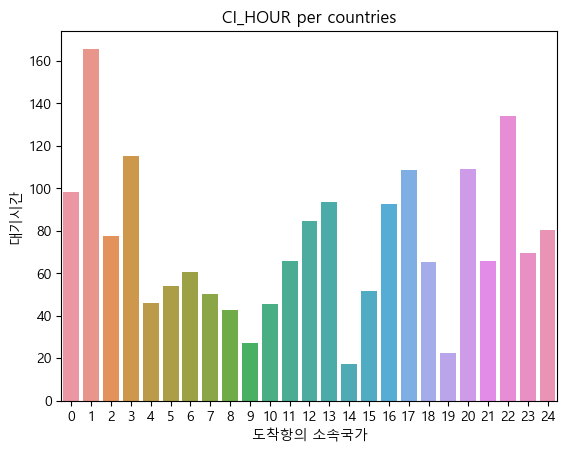

In [17]:
sns.barplot(x = train.groupby(['도착항의 소속국가']).mean().index, y = train.groupby(['도착항의 소속국가']).mean()['대기시간'])
plt.title(f'CI_HOUR per countries')
plt.show()
plt.close()

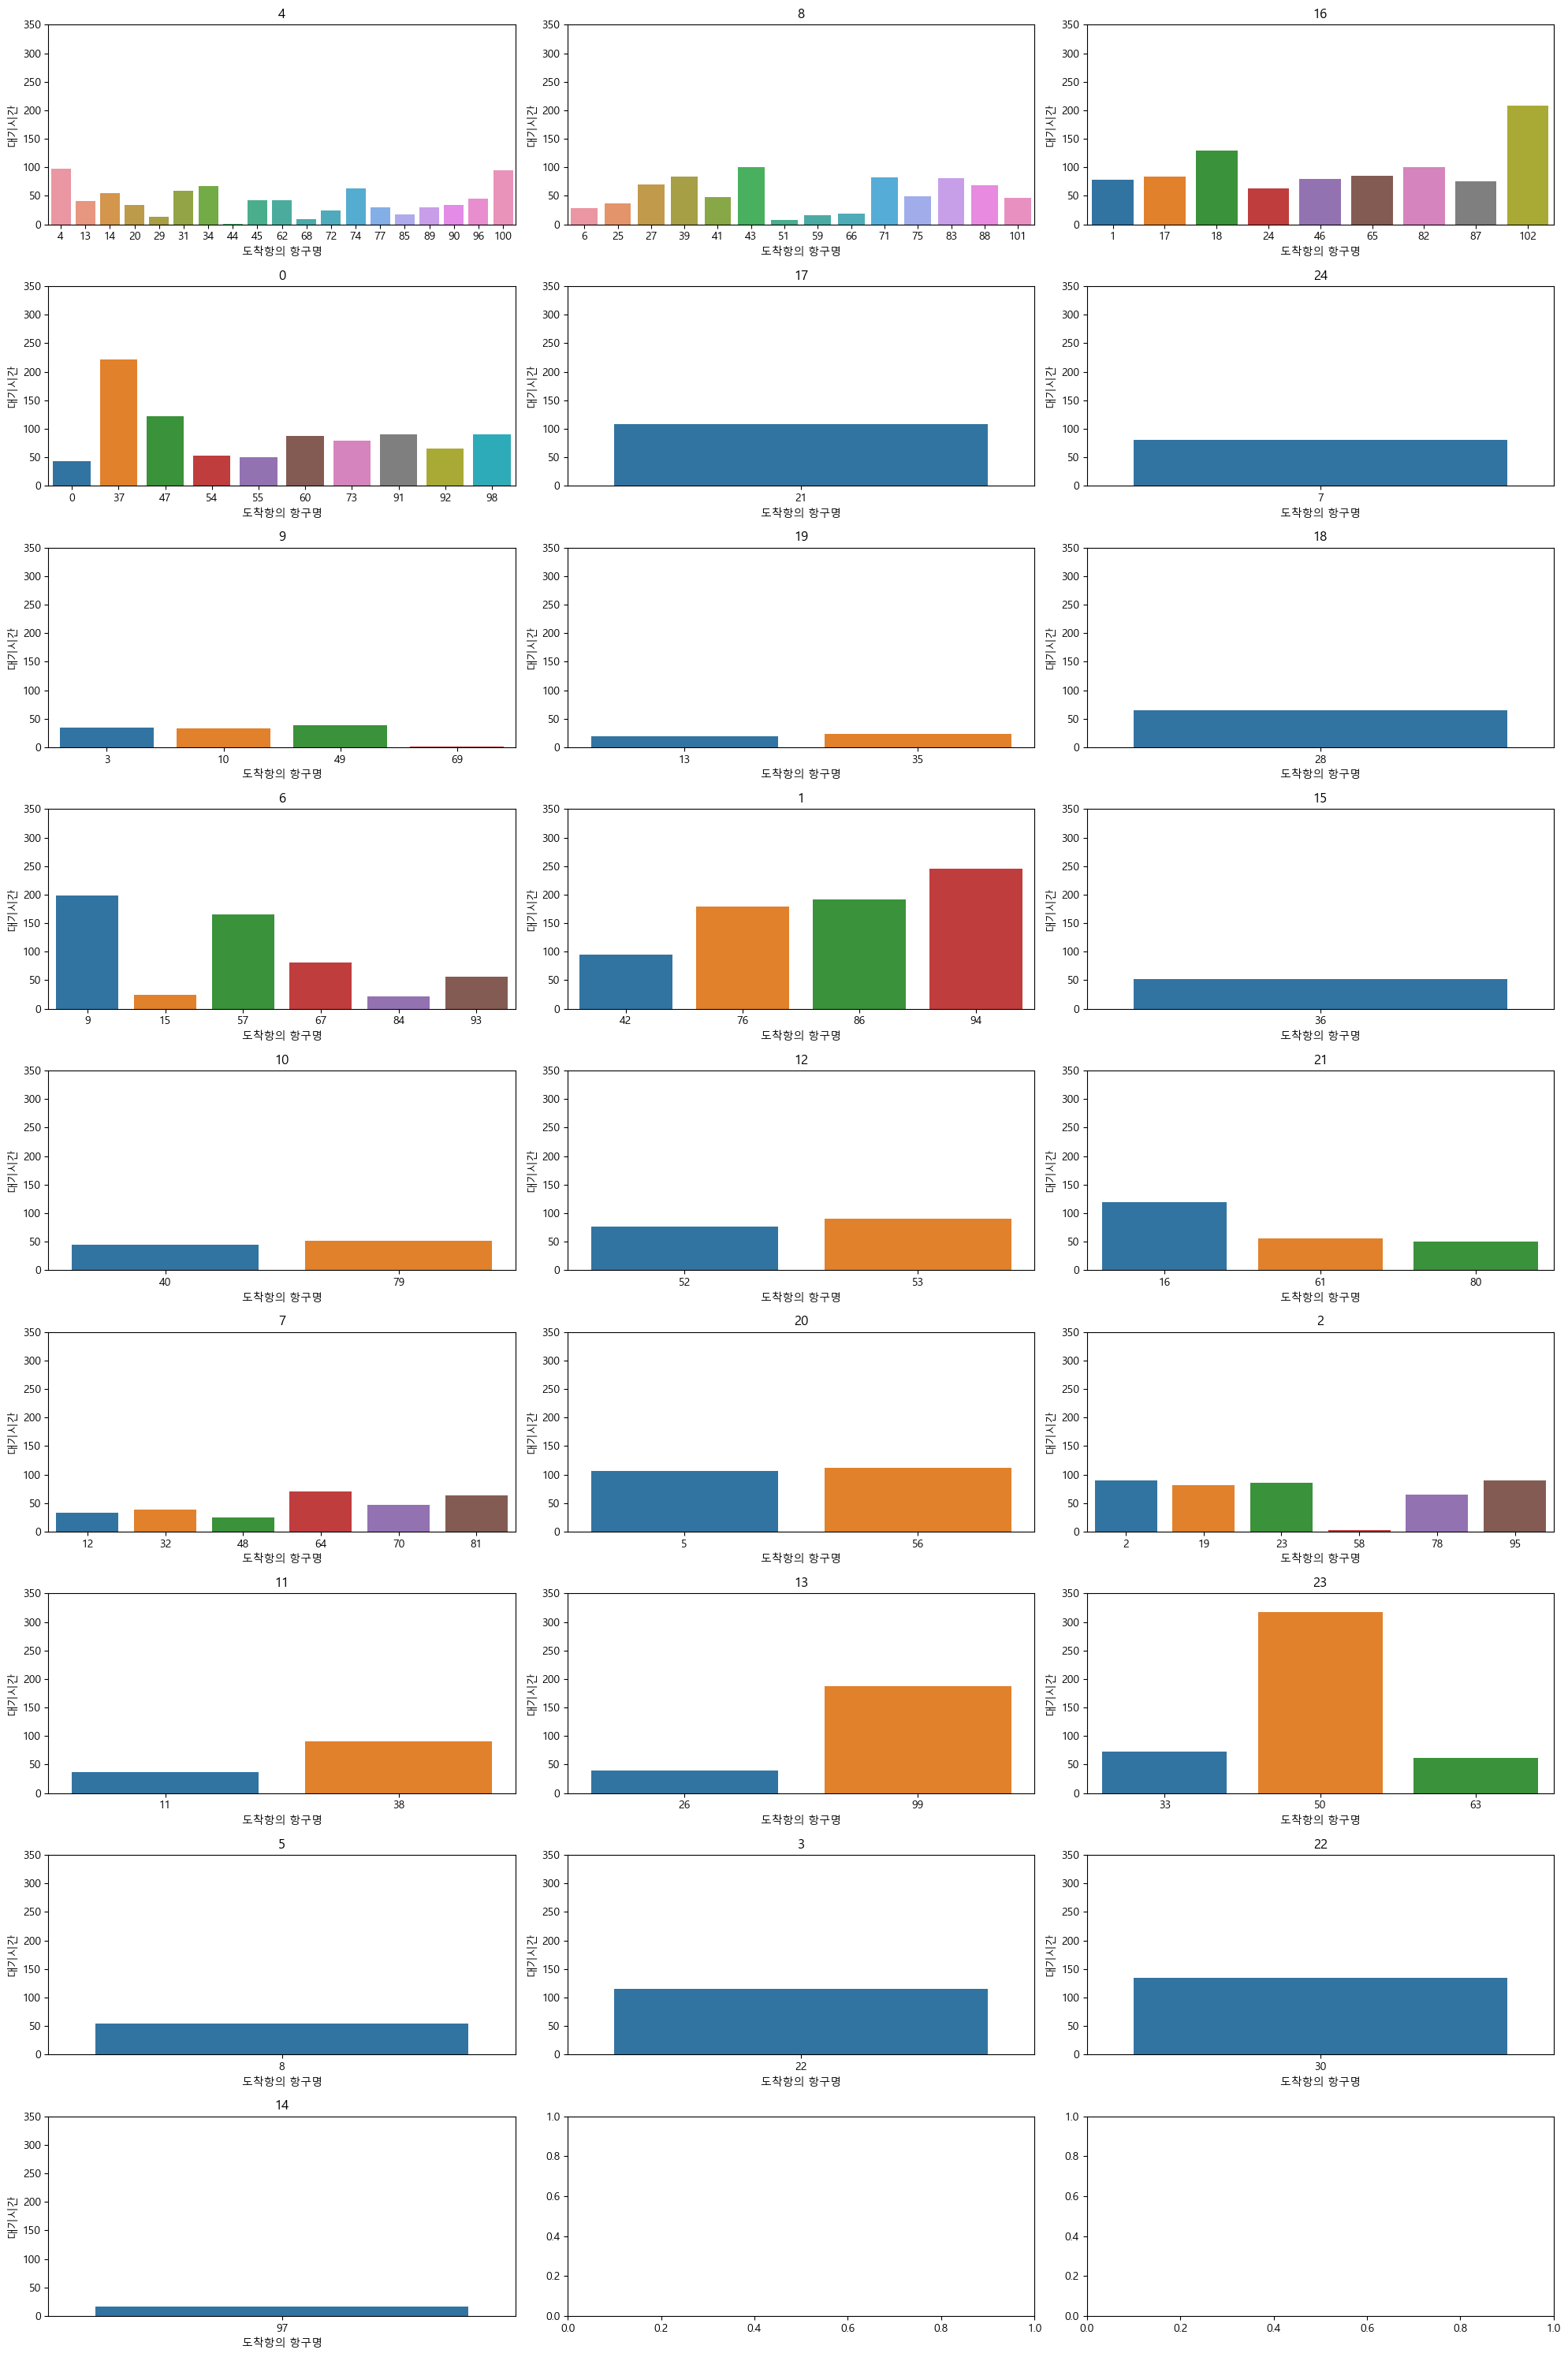

In [18]:
pd.options.mode.chained_assignment = None

x = len(train['도착항의 소속국가'].unique()) // 3 + 1

fig, ax = plt.subplots(x, 3, figsize = (20, x*3+3))

for idx, co in enumerate(train['도착항의 소속국가'].unique()):

    x = idx // 3
    y = idx % 3

    bar_width = 0.3

    train_ = train[train['도착항의 소속국가'] == co]
    x_d = train_.groupby(['도착항의 항구명']).mean().index
    y_d = train_.groupby(['도착항의 항구명']).mean()['대기시간']
    sns.barplot(x=x_d, y=y_d, ax=ax[x, y])
    ax[x, y].set_title(f'{co}')
    ax[x, y].set_ylim((0, 350))
    
plt.tight_layout()
plt.show()
plt.close()

## 모델 학습 및 특성 중요도 확인

Model Tune for LGBM.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


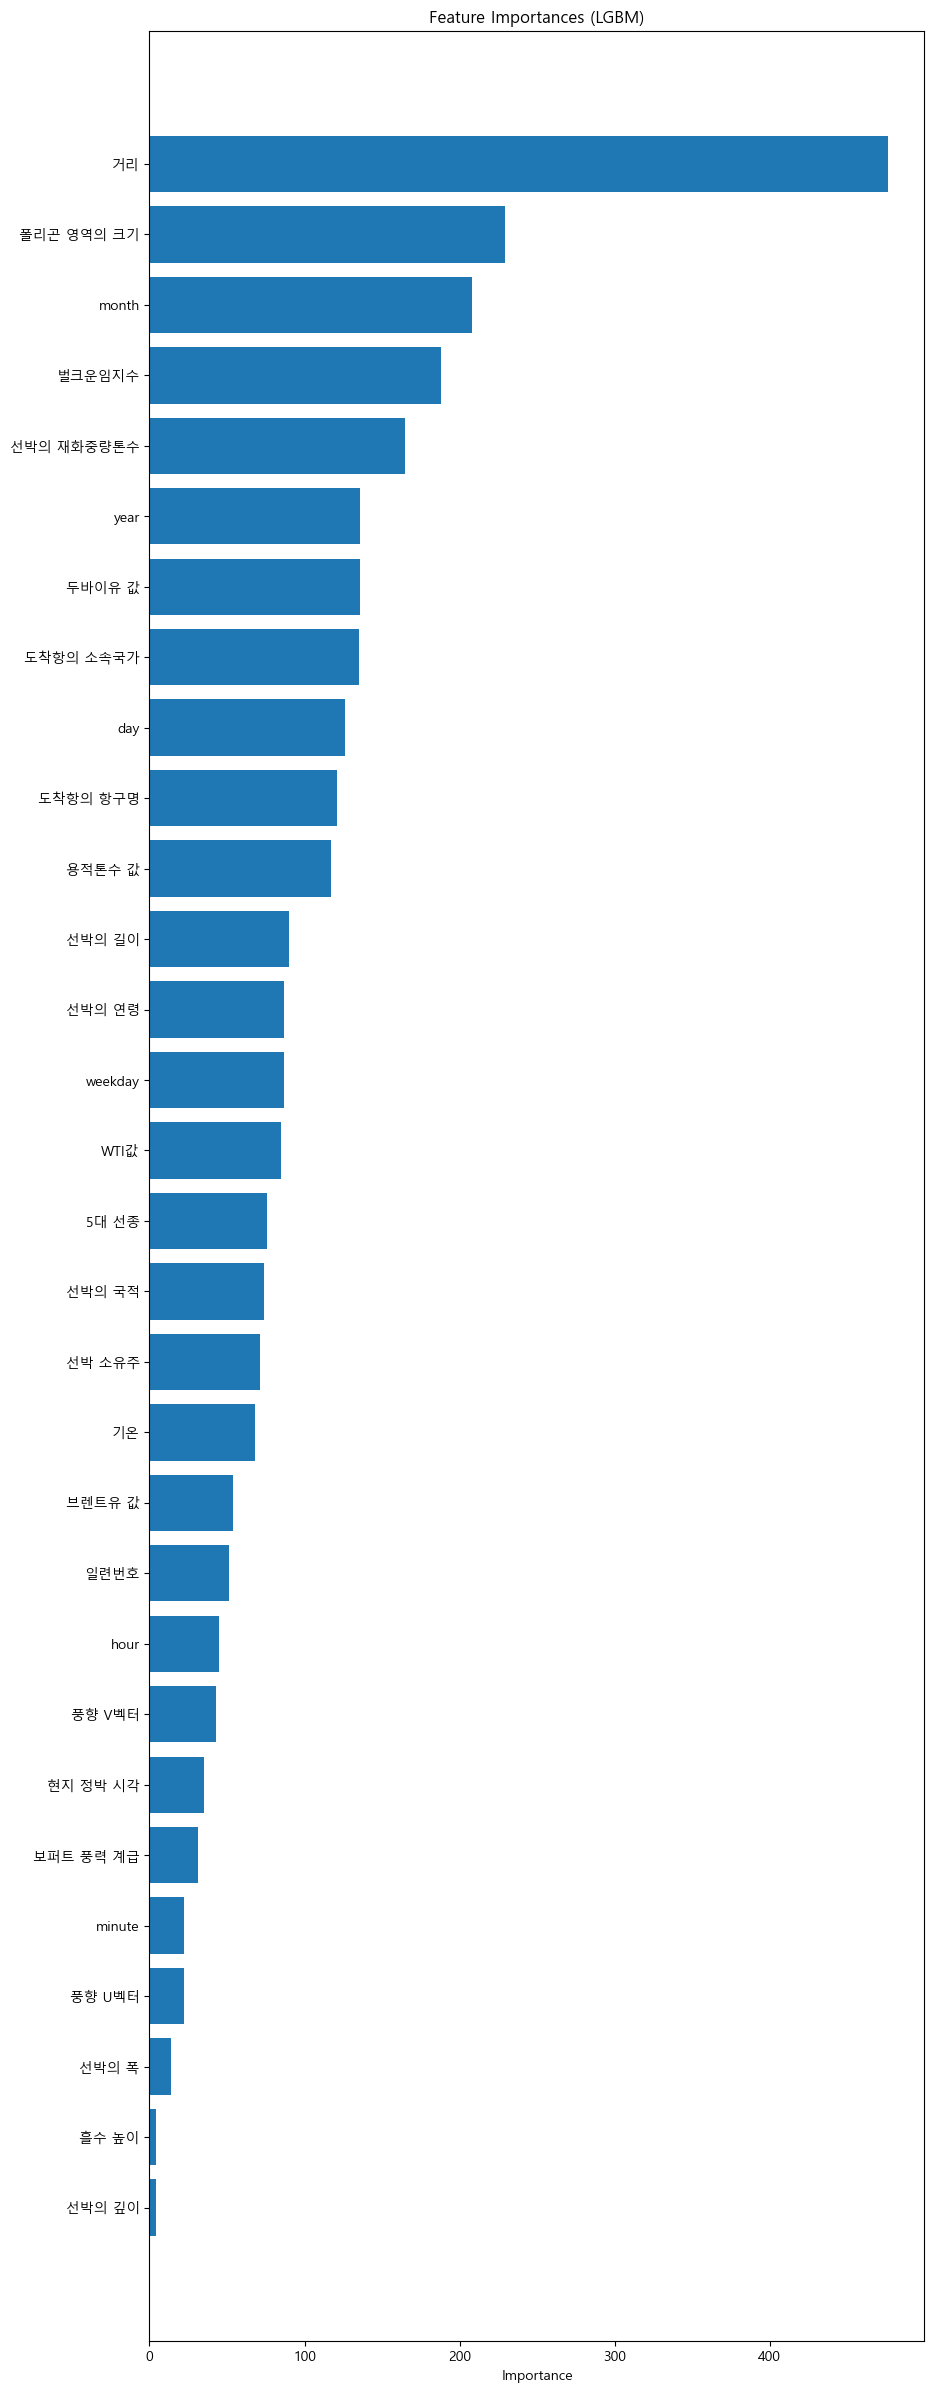

In [19]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns='대기시간')
y_train = train['대기시간']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

## 특성 중요도로부터 Feature Selection

In [20]:
threshold = 130 # Your Threshold 85
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns = low_importance_features)
X_test_reduced = test.drop(columns = low_importance_features)

## K-Fold Model Fitting & Validation

In [21]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]
    
    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)
    
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    
    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1171
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 8
[LightGBM] [Info] Start training from score 62.047288


Processing folds:  20%|██        | 1/5 [00:00<00:03,  1.06it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1171
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 8
[LightGBM] [Info] Start training from score 61.719969


Processing folds:  40%|████      | 2/5 [00:01<00:02,  1.06it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1171
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 8
[LightGBM] [Info] Start training from score 61.754815


Processing folds:  60%|██████    | 3/5 [00:02<00:01,  1.08it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1171
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 8
[LightGBM] [Info] Start training from score 61.868218


Processing folds:  80%|████████  | 4/5 [00:03<00:00,  1.11it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1171
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 8
[LightGBM] [Info] Start training from score 61.995298


Processing folds: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]

Validation : MAE scores for each fold: [52.19306357796444, 53.8227750830909, 52.979391226679205, 52.92096784878607, 52.38362597279724]
Validation : MAE: 52.85996474186358


## Submission

In [ ]:
# submit = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_AI_Challenge\sample_submission.csv')
# submit['CI_HOUR'] = final_predictions
# submit.to_csv('C:\\Users\\dlwks\\OneDrive\\바탕 화면\\VSCode\\HD_AI_Challenge\\0926_2.csv', index=False)